In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../")
from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.types import SimulationParameters, ConstantCurrentInjection, ConductanceOptions, FilterParameters, OptimizationParameters
from act.data_processing import get_summary_features, combine_data

In [2]:
# Define the cell
cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/orig/target_template.hoc",
    path_to_mod_files = "../../data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

target_g = np.array([0.0003, 0.12, 0.036])

In [16]:
grid_values = np.linspace(target_g - 0.5 * target_g, target_g + 0.5 * target_g, num = 40)

In [ ]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

index_counter = 0
for g_na_value in grid_values[:, 1]:
    for g_k_value in grid_values[:, 2]:
        cell = ACTCellModel(
        cell_name = "Spiker",
        path_to_hoc_file = "../../data/Spiker/orig/target_template.hoc",
        path_to_mod_files = "../../data/Spiker/orig/modfiles/",
        passive = ["gl", "el", None],
        active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
        )
        
        cell.set_g_bar(["hh_spiker.gnabar", "hh_spiker.gkbar"], [g_na_value, g_k_value])

        sim_params = SimulationParameters(
            sim_name = "cell",
            sim_idx = index_counter,
            h_celsius = 6.3,
            h_dt = 0.1,
            h_tstop = 1000,
            CI = [ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0)])
        index_counter += 1
        
        simulator.submit_job(cell, sim_params)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [62]:
simulator.run_jobs(5)

In [63]:
# Combine simulated traces into one dataset for convenience
combine_data("output/cell")

output/cell/combined_out.npy


In [7]:
data = np.load("output/cell/combined_out.npy")
V = data[:, :, 0][:, ::10]
I = data[:, :, 1][:, ::10]
g = data[:, :2, 2]

In [9]:
estimated_sf = get_summary_features(V, I, window = (100, 800))

In [66]:
simulator = ACTSimulator(output_folder_name = "output")

cell = ACTCellModel(
        cell_name = "Spiker",
        path_to_hoc_file = "../../data/Spiker/orig/target_template.hoc",
        path_to_mod_files = "../../data/Spiker/orig/modfiles/",
        passive = ["gl", "el", None],
        active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
        )

sim_params = SimulationParameters(
sim_name = "cell",
sim_idx = 999,
h_celsius = 6.3,
h_dt = 0.1,
h_tstop = 1000,
CI = [ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0)])

simulator.submit_job(cell, sim_params)
simulator.run_jobs(1)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [11]:
data = np.load("output/cell/out_999.npy")
V = data[::10, 0].reshape((1, -1))
I = data[::10, 1].reshape((1, -1))
target_sf = get_summary_features(V, I, window = (100, 800))

In [12]:
target_sf

,mean_v,std_v,n_spikes,spike_frequency,spike_0,spike_1,spike_2,spike_3,spike_4,spike_5,...,isi_11,isi_12,isi_13,isi_14,isi_15,isi_16,isi_17,isi_18,mean_i,std_i
0,-49.371034,21.479261,77,110.0,101.0,111.0,120.0,130.0,139.0,148.0,...,9.0,10.0,9.0,9.0,9.0,9.0,9.0,9.0,0.35,0.229129


In [13]:
# Z-transform the features
pred = estimated_sf.to_numpy()
z_mean = np.nanmean(pred, axis = 0)
z_std = np.nanstd(pred, axis = 0)

pred = (pred - z_mean) / z_std

# Use sample mean and std for target transformation
targ = target_sf.to_numpy() 
targ = (targ - z_mean) / z_std

mae = np.nanmean(np.abs(targ - pred), axis = 1)

/var/folders/gs/_z8_31zd6xz_w20ny978y50w0000gn/T/ipykernel_11496/157144236.py:6: RuntimeWarning: invalid value encountered in divide
  pred = (pred - z_mean) / z_std
/var/folders/gs/_z8_31zd6xz_w20ny978y50w0000gn/T/ipykernel_11496/157144236.py:10: RuntimeWarning: invalid value encountered in divide
  targ = (targ - z_mean) / z_std


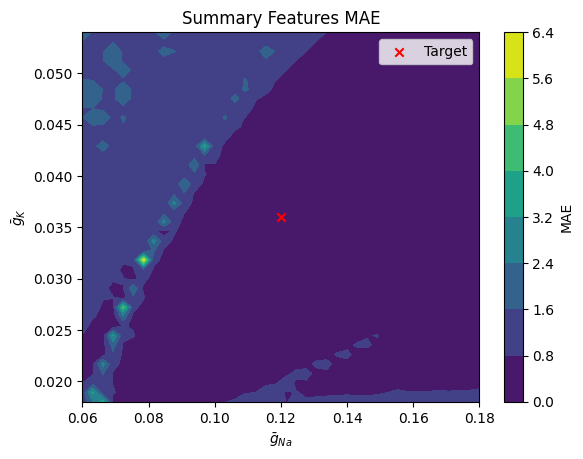

In [17]:
X, Y = np.meshgrid(grid_values[:, 1], grid_values[:, 2], indexing = 'ij')

fig, ax = plt.subplots()
contour = ax.contourf(X, Y, mae.reshape((grid_values.shape[0], grid_values.shape[0])), cmap = 'viridis')
ax.scatter(target_g[1], target_g[2], marker = "x", color = 'red', label = "Target")

ax.set_xlabel(r"$\bar{g}_{Na}$")
ax.set_ylabel(r"$\bar{g}_{K}$")
ax.set_title('Summary Features MAE')
ax.legend()

cbar = fig.colorbar(contour)
cbar.set_label('MAE')

In [2]:
from act.module import ACTModule

In [3]:
cell = ACTCellModel(
    cell_name = "Spiker",
    path_to_hoc_file = "../../data/Spiker/orig/target_template.hoc",
    path_to_mod_files = "../../data/Spiker/orig/modfiles/",
    passive = ["gl", "el", None],
    active_channels = ["hh_spiker.gnabar", "hh_spiker.gkbar"],
)

target_g = np.array([0.0003, 0.12, 0.036])

sim_params = SimulationParameters(
        sim_name = "cell",
        sim_idx = 0,
        h_celsius = 6.3,
        h_dt = 0.1,
        h_tstop = 1000)

optim_params = OptimizationParameters(
    conductance_options = [
        ConductanceOptions(variable_name = "hh_spiker.gl", low = 0, high = 1, n_slices = 3),
        ConductanceOptions(variable_name = "hh_spiker.gnabar", low = 0, high = 1, n_slices = 3),
        ConductanceOptions(variable_name = "hh_spiker.gkbar", low = 0, high = 1, n_slices = 3),  
    ],
    CI_options = [
        ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100, lto_hto = 0),
        ConstantCurrentInjection(amp = 0.1, dur = 700, delay = 100, lto_hto = 0)
    ],
    filter_parameters = FilterParameters(
        saturation_threshold = -55,
        window_of_inspection = (100, 800)
    )
)

In [4]:
m = ACTModule(
    name = "orig",
    cell = cell,
    simulation_parameters = sim_params,
    optimization_parameters = optim_params,
    target_file = "/Users/vladimiromelyusik/ACT/experiments/Spiker/output/target/combined_out.npy"
)

In [5]:
m.run()

Running Module orig...
----------
Simulating train traces...

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
/Users/vladimiromelyusik/ACT/experiments/Spiker/module_orig/train/combined_out.npy
Training RandomForest...
Train MAE:  0.17313888888888887
Predicting on target data...
[[0.5975 0.3705]
 [0.493  0.3815]
 [0.616  0.423 ]]

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/opt/anaconda3/envs/simulations/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


/Users/vladimiromelyusik/ACT/experiments/Spiker/module_orig/eval/combined_out.npy
Evaluating predictions...
{'hh_spiker.gl': 0.5975, 'hh_spiker.gnabar': 0.3705}
Done. Finished in 0:00:13.069641 sec.



/Users/vladimiromelyusik/ACT/experiments/Spiker/../../act/metrics.py:37: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/opt/anaconda3/envs/simulations/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/vladimiromelyusik/ACT/experiments/Spiker/../../act/metrics.py:39: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/Users/vladimiromelyusik/ACT/experiments/Spiker/../../act/metrics.py:42: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/Users/vladimiromelyusik/ACT/experiments/Spiker/../../act/metrics.py:42: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std
